#This Notebook does the second step in the split workflow on Terra

The NIFTI files generated from first step are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###Installing Packages

In [1]:
# %%capture
# #Installing lz4 for compression/decompression
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 xvfb

In [2]:
# %%capture
# #Installing Totalsegmentator for Inference
# #pyradiomics required for extracting radiomics features 
# #nvidia-ml-py3 for capturing gpu utilization
# !pip install TotalSegmentator pyradiomics nvidia-ml-py3

###Parameters for papermill

In [3]:
converterType='dcm2niix'
niftiFilePath=''

###Decompressing NIFTI files from first step

In [14]:
import glob

#Get the file path of the 

#lz4_file_path = '/content/drive/MyDrive/idc_vamsi/downloadDicomAndConvertNiftiFiles.tar.lz4'


!lz4 -d {niftiFilePath} -c | tar  --strip-components=1  -xvf -

#!lz4 -d /content/drive/MyDrive/idc_vamsi/downloadDicomAndConvertNiftiFiles.tar.lz4 -c | tar xvf -

dcm2niix/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.21767310514022109288482935440_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699/1.3.6.1.4.1.14519.5.2.1.7009.9004.18829027842807368985881109269_2_OPA_GE_LS16_STANDARD_320_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/1.3.6.1.4.1.14519.5.2.1.7009.9004.20157027537075965742961665827_2_OPA_GE_LS16_STANDARD_390_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.22309309779707871298

###Defining Functions

In [15]:
import os
import sys
import shutil
from pathlib import Path
import time

In [16]:
#create directory for TotalSegmentator Output files
try:
  shutil.rmtree('Inference')
except OSError:
  pass
os.mkdir('Inference')

In [17]:
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Thu Mar 30 21:04:33 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


In [18]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import nvidia_smi

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

In [19]:
def inferenceTotalSegmentator(series_id):
      try:
        shutil.rmtree(f'Inference/{series_id}')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')

      print("Processing series: "+series_id)  

      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
      print(nifti_filename_path)

      start_time = time.time()
      !TotalSegmentator -i {nifti_filename_path} -o {curr_dir}/Inference/{series_id}/{series_id}.nii.gz --ml --fast --preview  --radiomics 
      total_segmentator_time = time.time() - start_time

      start_time = time.time()     
      !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii.gz  {curr_dir}/Inference/{series_id}/{series_id}.nii.gz.lz4
      archiving_time = time.time() - start_time

      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}/{series_id}.nii.gz
      !rm -r {curr_dir}/{converterType}/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

###Total Segmentator

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/1.3.6.1.4.1.14519.5.2.1.7009.9004.20157027537075965742961665827_2_OPA_GE_LS16_STANDARD_390_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Download finished. Extracting...
  downloaded in 5.02s
Resampling...
  Resampled in 6.08s
Predicting...
  Predicted in 16.82s
Generating preview...
  Generated in 7.01s
Resampling...
Saving segmentations...
  Saved in 3.10s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.13s
Compressed 2063678 bytes into 1536245 bytes ==> 74.44%


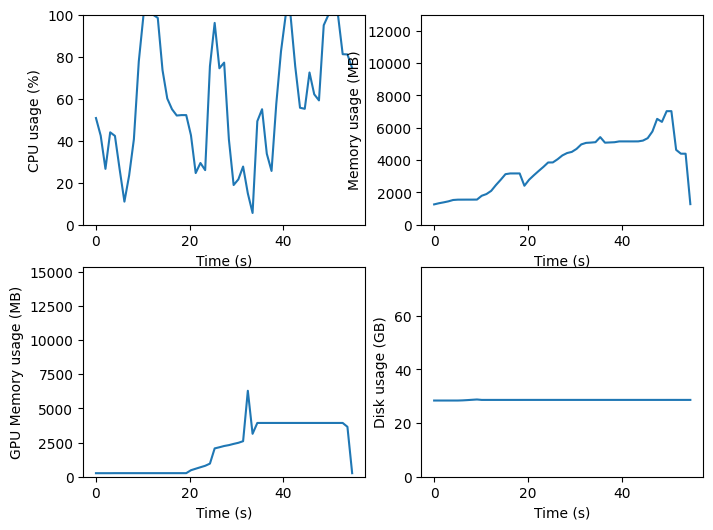

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.21767310514022109288482935440_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.42s
Predicting...
  Predicted in 8.79s
Generating preview...
  Generated in 3.44s
Resampling...
Saving segmentations...
  Saved in 1.78s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 2023504 bytes into 1465853 bytes ==> 72.44%


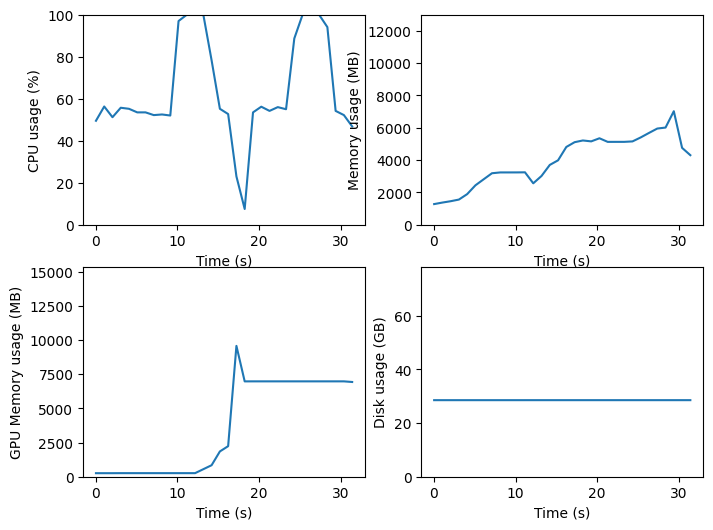

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699/1.3.6.1.4.1.14519.5.2.1.7009.9004.18829027842807368985881109269_2_OPA_GE_LS16_STANDARD_320_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.29s
Predicting...
  Predicted in 8.49s
Generating preview...
  Generated in 4.57s
Resampling...
Saving segmentations...
  Saved in 2.07s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.08s
Compressed 2011392 bytes into 1479305 bytes ==> 73.55%


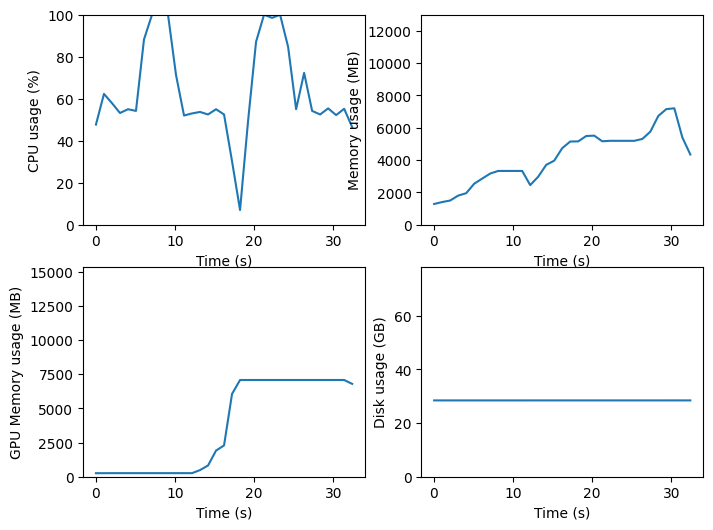

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052022558158291630814
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052022558158291630814/1.3.6.1.4.1.14519.5.2.1.7009.9004.27821690605202255815829163081_2_OPA_GE_LS16_STANDARD_340_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.25s
Predicting...
  Predicted in 9.30s
Generating preview...
  Generated in 4.19s
Resampling...
Saving segmentations...
  Saved in 2.87s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.12s
Compressed 2004740 bytes into 1474688 bytes ==> 73.56%


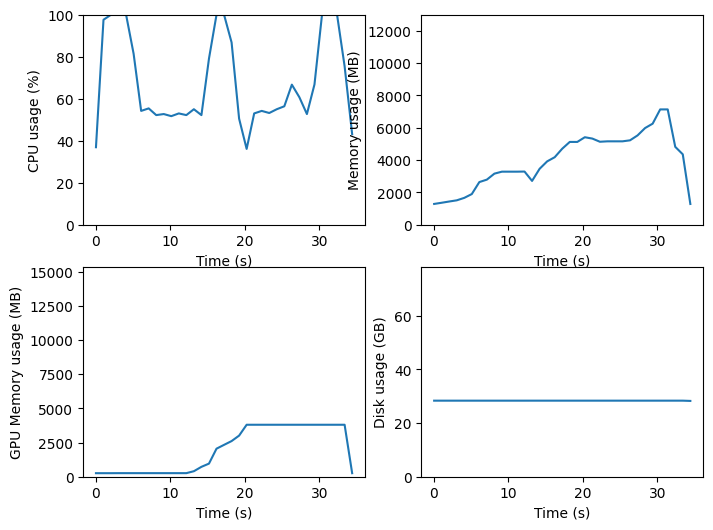

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262/1.3.6.1.4.1.14519.5.2.1.7009.9004.20702362170585978578275694726_2_OPA_GE_LSPR16_STANDARD_360_1.2_120_80_58.2_1.4_20010102000000_3.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 5.54s
Predicting...
  Predicted in 7.75s
Generating preview...
  Generated in 2.77s
Resampling...
Saving segmentations...
  Saved in 2.14s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 1726149 bytes into 1314612 bytes ==> 76.16%


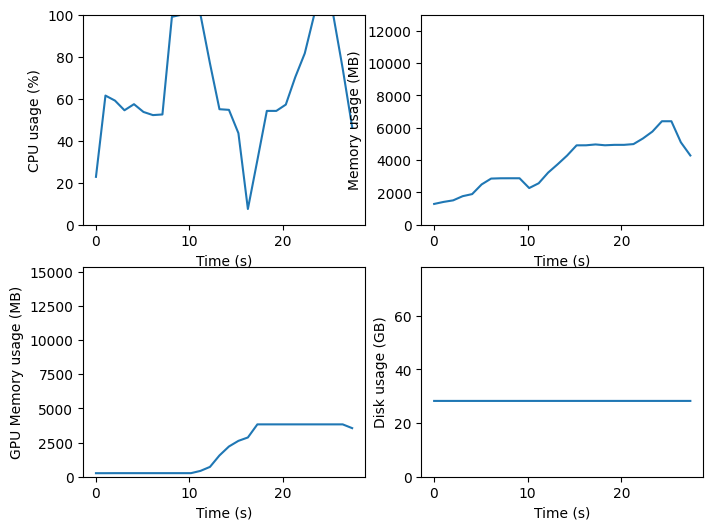

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210222351126080087655
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210222351126080087655/1.3.6.1.4.1.14519.5.2.1.7009.9004.23214278521022235112608008765_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.56s
Predicting...
  Predicted in 8.18s
Generating preview...
  Generated in 5.44s
Resampling...
Saving segmentations...
  Saved in 2.47s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 2518052 bytes into 1981548 bytes ==> 78.69%


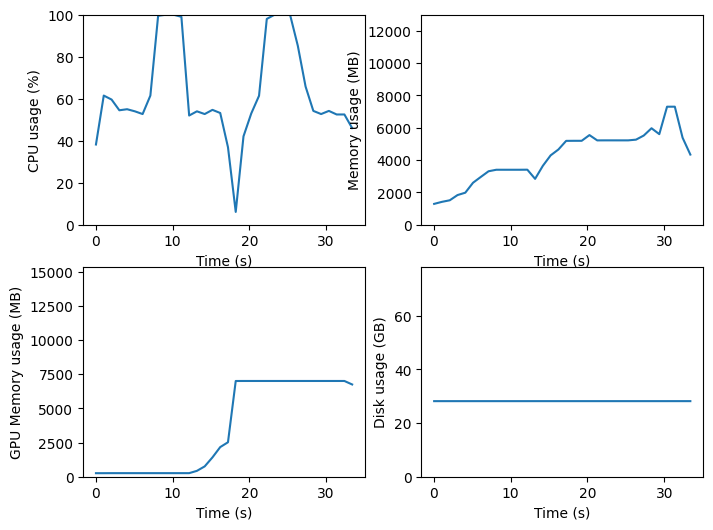

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/1.3.6.1.4.1.14519.5.2.1.7009.9004.46300957483180052981221000308_2_OPA_GE_LS16_STANDARD_340_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.39s
Predicting...
  Predicted in 9.26s
Generating preview...
  Generated in 5.06s
Resampling...
Saving segmentations...
  Saved in 2.88s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 2076580 bytes into 1481814 bytes ==> 71.36%


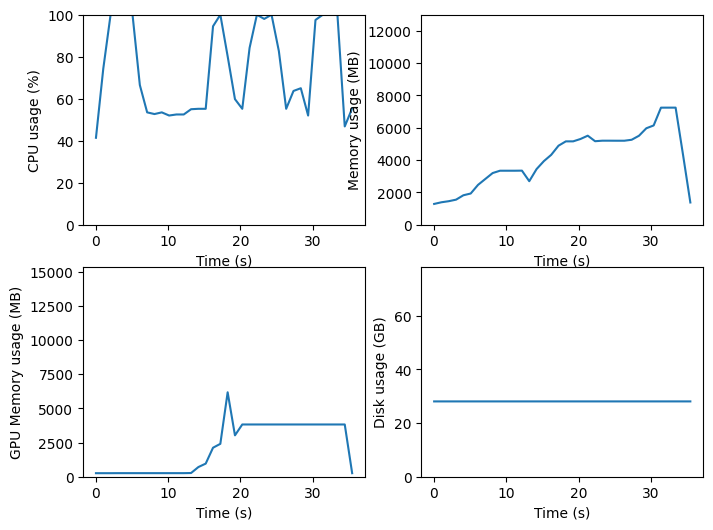

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411/1.3.6.1.4.1.14519.5.2.1.7009.9004.21032547814736332903178735541_2_OPA_GE_LS16_STANDARD_382_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.40s
Predicting...
  Predicted in 8.48s
Generating preview...
  Generated in 6.50s
Resampling...
Saving segmentations...
  Saved in 1.65s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 2389678 bytes into 1822230 bytes ==> 76.25%


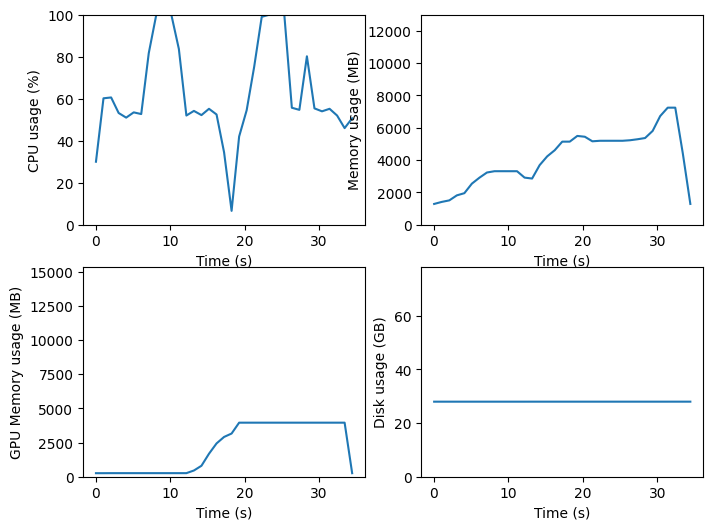

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105/1.3.6.1.4.1.14519.5.2.1.7009.9004.18390137279872191174337969010_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.01s
Predicting...
  Predicted in 9.33s
Generating preview...
  Generated in 4.27s
Resampling...
Saving segmentations...
  Saved in 2.66s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 2030914 bytes into 1451767 bytes ==> 71.48%


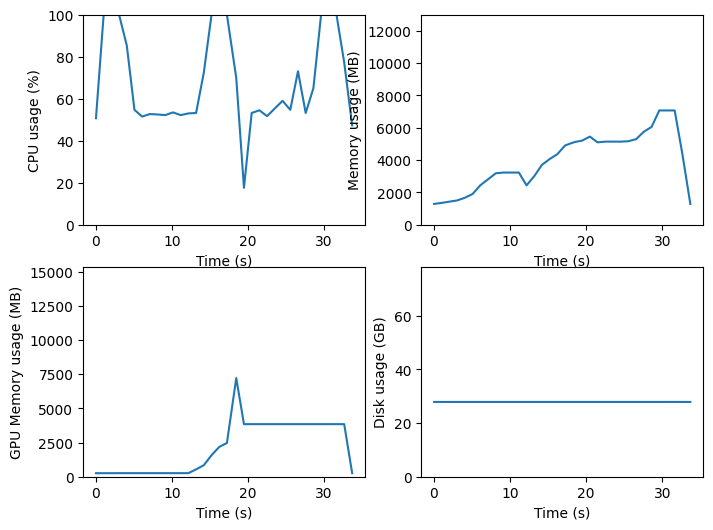

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/1.3.6.1.4.1.14519.5.2.1.7009.9004.22309309779707871298302147650_2_OPA_GE_LS16_STANDARD_430_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.44s
Predicting...
  Predicted in 8.63s
Generating preview...
  Generated in 7.91s
Resampling...
Saving segmentations...
  Saved in 1.66s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 2108097 bytes into 1492127 bytes ==> 70.78%


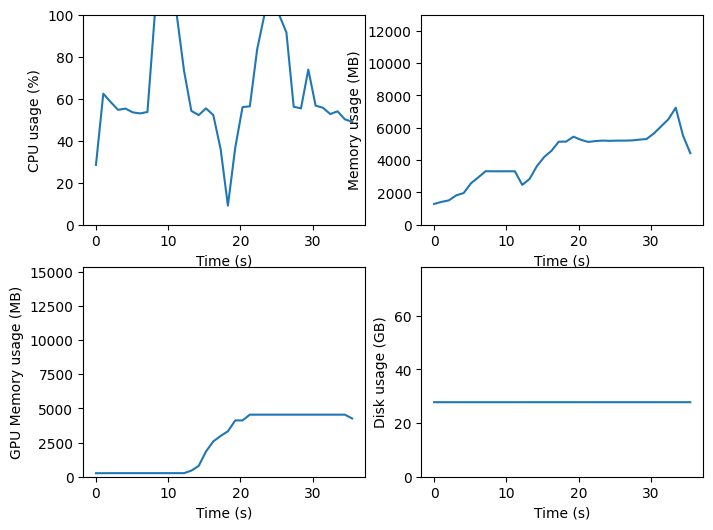

In [20]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'{curr_dir}/{converterType}'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [21]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
except OSError:
  pass
!tar cvf - Inference | lz4 > inferenceNiftiFiles.tar.lz4
archiving_time = time.time() - start_time


Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271.nii.gz.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405.nii.gz.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092

###Utilization Metrics

In [22]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['archiving_time']=archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats

Compressed 20127 bytes into 7614 bytes ==> 37.83%


,SeriesInstanceUID,total_segmentator_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,gpu_usage_mb,gpu_total_mb,gpu_type,disk_usage_all,disk_total
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370...,54.669660,0.130256,"[[[50.8, 42.4, 26.6, 44.0, 42.3, 26.3, 11.0, 2...","[[[1257.5390625, 1327.640625, 1382.74609375, 1...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 261...",[15360.0],b'Tesla T4',"[[[28.369064331054688, 28.369064331054688, 28....",78.189842
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140...,31.956870,0.130256,"[[[49.5, 56.3, 51.2, 55.7, 55.2, 53.5, 53.5, 5...","[[[1275.96484375, 1370.265625, 1453.734375, 15...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.505531311035156, 28.505535125732422, 28....",78.189842
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428...,32.753737,0.130256,"[[[47.7, 62.3, 57.9, 53.2, 55.0, 54.2, 88.2, 1...","[[[1282.84765625, 1401.44921875, 1496.2265625,...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.41297149658203, 28.412975311279297, 28.4...",78.189842
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052...,34.065987,0.130256,"[[[36.9, 97.6, 100.0, 100.0, 100.0, 81.4, 54.2...","[[[1285.66015625, 1358.4296875, 1435.65625, 15...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.317508697509766, 28.31751251220703, 28.3...",78.189842
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705...,27.635307,0.130256,"[[[22.8, 61.5, 59.1, 54.5, 57.4, 53.7, 52.2, 5...","[[[1285.5234375, 1410.82421875, 1507.18359375,...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.223278045654297, 28.223281860351562, 28....",78.189842
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210...,33.852858,0.130256,"[[[38.2, 61.5, 59.6, 54.5, 55.0, 54.0, 52.7, 6...","[[[1288.66796875, 1414.5546875, 1511.2421875, ...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.140533447265625, 28.14053726196289, 28.1...",78.189842
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831...,35.490642,0.130256,"[[[41.4, 74.3, 100.0, 100.0, 100.0, 100.0, 66....","[[[1285.7890625, 1388.61328125, 1454.83203125,...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.040058135986328, 28.040061950683594, 28....",78.189842
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147...,34.381352,0.130256,"[[[30.0, 60.2, 60.6, 53.2, 51.0, 53.5, 52.7, 8...","[[[1284.796875, 1409.55859375, 1505.390625, 18...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.943092346191406, 27.943096160888672, 27....",78.189842
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798...,33.506717,0.130256,"[[[50.7, 100.0, 100.0, 100.0, 85.4, 54.7, 51.5...","[[[1287.296875, 1350.80859375, 1427.88671875, ...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.840587615966797, 27.840587615966797, 27....",78.189842
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797...,35.679539,0.130256,"[[[28.5, 62.4, 58.4, 54.7, 55.3, 53.5, 53.0, 5...","[[[1285.62109375, 1411.37890625, 1507.47265625...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.747169494628906, 27.747173309326172, 27....",78.189842
